In [1]:
# imports
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import os
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from functools import partial

path = os.path.dirname(os.getcwd())
os.chdir(path)

from src.BayesIMP import *
from src.kernels import *
from src.GP_utils import *
from src.training_utils import *
from src.kernel_utils import *
from src.dgps import *

### Drawing data

In [8]:
# DGP set up
torch.random.manual_seed(1)
d = 1
train_samples = 100
test_samples = 1000
noise_variance = 0.1
input_distribution = torch.distributions.uniform.Uniform(0,1)
mc_samples_EY = 10**4 # MC samples for E[Y|doA] approximation

# PLotting settings
z_val = 1.96

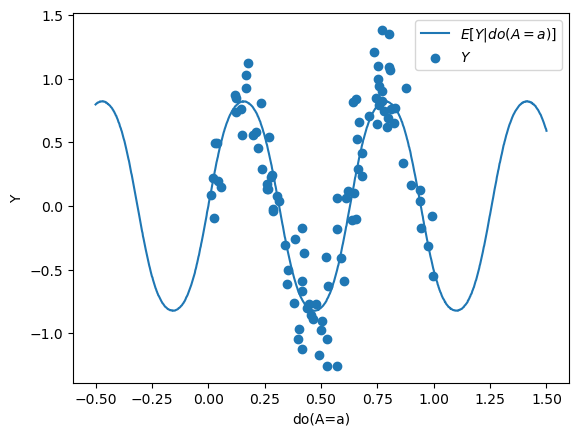

In [9]:
# Dataset generation and plotting E[Y|do(A)]
torch.random.manual_seed(1)
coefs_v = 10*torch.linspace(1,4,d).view(1,d)
coefs_y = 1/torch.linspace(1,d,d).view(d,)

A = input_distribution.sample((train_samples,1))
doA = torch.linspace(-0.5,1.5,test_samples).view(test_samples,1)
fv = f_x(A,coefs_v)
noise_distribution = torch.distributions.normal.Normal(0,(noise_variance*fv.var(0))**0.5)
V = fv+noise_distribution.sample((train_samples,))
fy = f_y(V,coefs_y)
Y = torch.distributions.normal.Normal(fy,(noise_variance*fy.var())**0.5).sample()

# Grid-points to approximate true E[Y|do(A)]
Vtest = (f_x(doA,coefs_v).T[:,:,None] @ torch.ones(mc_samples_EY).view(1,mc_samples_EY) + noise_distribution.sample((mc_samples_EY,test_samples)).T)
EYdoA = f_y(Vtest.T,coefs_y).mean(1).view(test_samples,1)

# Plot
indices = torch.argsort(doA,0)[:,0]
indices_train = torch.argsort(A,0)[:,0]
plt.plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A=a)]$")
plt.scatter(A,Y, label = r"$Y$")
plt.xlabel("do(A=a)")
plt.ylabel("Y")
plt.legend()
plt.show()

### Running BayesIMP

In [15]:
# BayesIMP settings
nulist = 2**torch.linspace(-2,2,3)*(V.var()**0.5)
print(nulist)

Kernels_V = []
Noise_Y =  []
Kernels_A = []
Noise_feat =  []

tensor([0.1885, 0.7538, 3.0154])


In [16]:
## Training BayesIMP
learn_rate = 0.05
n_iter = 500

n = train_samples

for k in range(len(nulist)):
    nu = torch.tensor([nulist[k]]).requires_grad_(False)
    
    """
    Training P(Y|V)
    """
    # Initialisation
    kernel_V_scale = torch.tensor([1.0], requires_grad = True)
    kernel_V_ls = torch.tensor([d**0.5*1.0]).repeat(d).requires_grad_(True)
    noise_Y = torch.tensor([-2.0],requires_grad = True).float()
    kernel_V = NuclearGaussianKernel(lengthscale = kernel_V_ls,
                                     scale = kernel_V_scale,
                                     sigma = nu)
    # Optimiser set up
    optimizer = torch.optim.Adam([kernel_V.lengthscale,
                                  kernel_V.scale,
                                  kernel_V.sigma,
                                  noise_Y], lr=learn_rate)
    Losses = torch.zeros(n_iter)

    # Updates
    for i in range(n_iter):
        optimizer.zero_grad()
        loss = -GPML(Y, V, kernel_V, torch.exp(noise_Y))
        Losses[i] = loss.detach()
        loss.backward()
        optimizer.step()
        if not i % 100:
                print("iter {0} loss: ".format(i), Losses[i])

    # Storing
    with torch.no_grad():
        Kernels_V.append(kernel_V)
        Noise_Y.append(torch.exp(noise_Y))

iter 0 loss:  tensor(39.6962)
iter 100 loss:  tensor(-5.8197)
iter 200 loss:  tensor(-6.1800)
iter 300 loss:  tensor(-6.2608)
iter 400 loss:  tensor(-6.3043)
iter 0 loss:  tensor(18.6829)
iter 100 loss:  tensor(-7.0549)
iter 200 loss:  tensor(-7.0557)
iter 300 loss:  tensor(-7.0550)
iter 400 loss:  tensor(-7.0558)
iter 0 loss:  tensor(17.9362)
iter 100 loss:  tensor(-7.1007)
iter 200 loss:  tensor(-7.1009)
iter 300 loss:  tensor(-7.1008)
iter 400 loss:  tensor(-7.1005)


In [17]:
for k in range(len(nulist)):
    nu = Kernels_V[k].sigma

    """
    Training P(V|A)
    """
    learn_rate = 0.05
    n_iter=500
    
    # Initialisation
    med_heur = median_heuristic(A)
    kernel_A = GaussianKernel(lengthscale = torch.tensor(med_heur, requires_grad = True),
                              scale = torch.tensor([1.0], requires_grad = True))
    noise_feat = torch.tensor(-2.0, requires_grad = True)
    
    # Optimiser set up
    optimizer = torch.optim.Adam([kernel_A.scale,noise_feat], lr=learn_rate)
    Losses = torch.zeros(n_iter)
    
    # Updates
    for i in range(n_iter):
        optimizer.zero_grad()
        loss =  -GPfeatureML(V, A, kernel_V, kernel_A, torch.exp(noise_feat))
        Losses[i] = loss.detach()
        loss.backward()
        optimizer.step()
        if not i % 100:
            print("iter {0} loss: ".format(i), Losses[i])
    
    # Storing
    with torch.no_grad():
        Kernels_A.append(kernel_A)
        Noise_feat.append(torch.exp(noise_feat))     

/tmp/ipykernel_153016/269073597.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel_A = GaussianKernel(lengthscale = torch.tensor(med_heur, requires_grad = True),


iter 0 loss:  tensor(-52362.3516)
iter 100 loss:  tensor(-66046.8828)
iter 200 loss:  tensor(-66047.6719)
iter 300 loss:  tensor(-66047.6250)
iter 400 loss:  tensor(-66047.6250)
iter 0 loss:  tensor(-52362.3516)
iter 100 loss:  tensor(-66046.8828)
iter 200 loss:  tensor(-66047.6719)
iter 300 loss:  tensor(-66047.6250)
iter 400 loss:  tensor(-66047.6250)
iter 0 loss:  tensor(-52362.3516)
iter 100 loss:  tensor(-66046.8828)
iter 200 loss:  tensor(-66047.6719)
iter 300 loss:  tensor(-66047.6250)
iter 400 loss:  tensor(-66047.6250)


nu =  tensor(0.1885) 95% CI width:  tensor(nan)
nu =  tensor(0.7538) 95% CI width:  tensor(nan)
nu =  tensor(3.0154) 95% CI width:  tensor(nan)


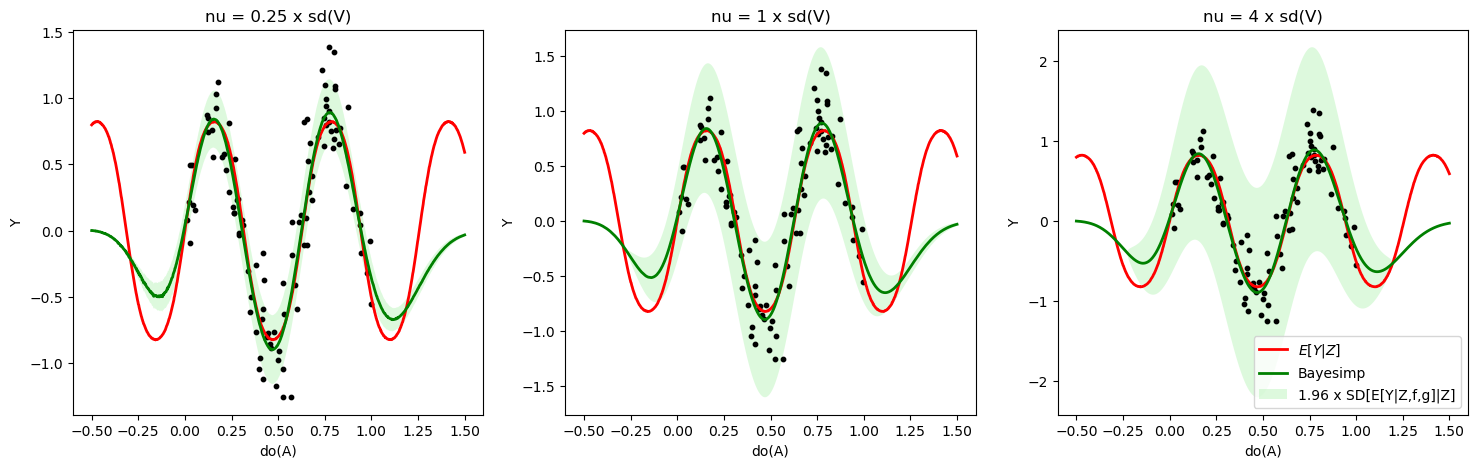

In [18]:
# Getting posterior moments and plotting results
fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))

for k in range(len(nulist)):
    kernel_A = Kernels_A[k]
    kernel_V = Kernels_V[k]
    noise_Y = Noise_Y[k]
    noise_feat = Noise_feat[k]

    
    # getting post mean predictions
    Bayesimp = BayesIMP(kernel_A, kernel_V, [], noise_Y, noise_feat)
    Bayesimp_mu = Bayesimp.post_mean(Y, A, V, doA).detach()
    Bayesimp_var = Bayesimp.post_var(Y, A, V, doA, reg = 1e-2).detach()
    
    # Getting CI
    indices = torch.argsort(doA,0)[:,0]
    indices_train = torch.argsort(A,0)[:,0]
    Upper = (Bayesimp_mu[indices]+z_val*torch.sqrt(torch.diag(Bayesimp_var[indices])))
    Lower = (Bayesimp_mu[indices]-z_val*torch.sqrt(torch.diag(Bayesimp_var[indices])))
    print("nu = ", nulist[k],"95% CI width: ", (Upper - Lower).mean())

    axs[k].plot(doA[indices],EYdoA[indices], label = r"$ E[Y|Z]$", color = "red", linewidth = 2)
    axs[k].plot(doA[indices],Bayesimp_mu[indices], label = r"Bayesimp", color = "green", linewidth = 2)
    axs[k].fill_between(doA[indices][:,0],Upper,Lower, color = "lightgreen",alpha=0.3, edgecolor='none', label = "1.96 x SD[E[Y|Z,f,g]|Z]")
    axs[k].scatter(A,Y, s = 10, color = "black")
    axs[k].set_xlabel("do(A)")
    axs[k].set_ylabel("Y")
    axs[k].set_title("nu = " + str(2**(-2+2*k))+" x sd(V)")
plt.legend()
plt.show()
fig.savefig("d={0}_Bayesimp".format(d), bbox_inches = "tight")

### Implementing our method

In [8]:
# Initialisation
kernel_x_scale = torch.tensor([1])
kernel_x_ls = torch.tensor([d**0.5*1.0]).repeat(d)
kernel_params_x = torch.cat((kernel_x_scale,kernel_x_ls)).clone().detach().requires_grad_(True)
y_noise = torch.tensor(-2.0,requires_grad = True).float()
kernel_params_z = torch.ones(2,requires_grad = True).float()
z_noise = torch.tensor(-2.0,requires_grad = True).float()

In [9]:
## Training P(Y|X)

# Optimiser set up
optimizer = torch.optim.Adam([kernel_params_x,y_noise], lr=0.1)
n_iter=200
Losses = torch.zeros(n_iter)

# Updates
for i in range(n_iter):
    optimizer.zero_grad()
    K_xx = get_gram_gaussian(X, X, kernel_params_x)
    loss = -torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(train_samples),
                                                                     K_xx+torch.exp(y_noise)*torch.eye(train_samples)).log_prob(Y)
    Losses[i] = loss.detach()
    loss.backward() # get gradients
    optimizer.step()
print(Losses[[0,n_iter-1]], torch.exp(y_noise))

tensor([17.5612, -5.1382]) tensor(0.0449, grad_fn=<ExpBackward0>)


In [10]:
## Training P(X|Z) via P(Y|Z)
train_method = "CV"
n = train_samples
Dist = torch.cdist(Z,Z, p = 2.0)**2
Lower_tri = torch.tril(Dist, diagonal=0).view(n**2).sort(descending = True)[0]
Lower_tri = Lower_tri[Lower_tri!=0]
median = Lower_tri.median()
z_scale = torch.ones(1,requires_grad = True).float()
z_ls = torch.tensor([(median/2).sqrt()], requires_grad = True)
z_noise = torch.tensor(-2.0,requires_grad = True).float()
nu = 1

# Optimiser set up
optimizer = torch.optim.Adam([z_scale, z_ls, z_noise], lr=0.1)
n_iter=0
Losses = torch.zeros(n_iter)
K_xx = get_gram_gaussian(X,X,kernel_params_x).detach()
eigs_s_sum = get_Gaussian_kernel_eigs(X, kernel_params_x.detach(), mc_approx = True, mc_samples = 10**3, nu = nu).sum()


# Updates
for i in range(n_iter):
    kernel_params_z = torch.cat((z_scale,z_ls))
    optimizer.zero_grad()
    if train_method == "ML":
        K_zz = get_gram_gaussian(Z, Z, kernel_params_z)+torch.eye(n)*torch.exp(z_noise)
        L = torch.linalg.cholesky(K_zz)
        loss  = eigs_s_sum*2*torch.diag(L).log().sum()+torch.trace(torch.linalg.solve(K_zz,K_xx))
    else:
        loss  = get_CV_loss(
                Y,X,Z, 
                kernel_params_x,kernel_params_z, 
                torch.exp(y_noise), torch.exp(z_noise), func = marginal_posterior_mean, folds = 10)  
    Losses[i] = loss.detach()
    loss.backward() # get gradients
    optimizer.step()
    print(Losses[i], torch.exp(z_noise))
    
n_iter=200
Losses = torch.zeros(n_iter)
train_method = "ML"
optimizer = torch.optim.Adam([z_scale, z_noise], lr=0.1)

# Updates
for i in range(n_iter):
    kernel_params_z = torch.cat((z_scale,z_ls))
    optimizer.zero_grad()
    if train_method == "ML":
        K_zz = get_gram_gaussian(Z, Z, kernel_params_z)+torch.eye(n)*torch.exp(z_noise)
        L = torch.linalg.cholesky(K_zz)
        loss  = eigs_s_sum*2*torch.diag(L).log().sum()+torch.trace(torch.linalg.solve(K_zz,K_xx))
    else:
        loss  = get_CV_loss(
                Y,X,Z, 
                kernel_params_x,kernel_params_z, 
                torch.exp(y_noise), torch.exp(z_noise), func = marginal_posterior_mean, folds = 10)  
    Losses[i] = loss.detach()
    loss.backward() # get gradients
    optimizer.step()
print(Losses[[0,i]], torch.exp(z_noise))

tensor([-186.9084, -361.7032]) tensor(0.0104, grad_fn=<ExpBackward0>)


In [3]:
fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))

for k in range(len(nulist)):
    K_xx_tilde_s = get_smoothed_Gaussian_kernel(X, kernel_params_x.detach(), mc_approx = True, mc_samples = 10**5, nu = nu)
    eigs_s_sum = get_Gaussian_kernel_eigs(X, kernel_params_x.detach(), mc_approx = True, mc_samples = 10**3, nu = nu).sum()

    EY_Z = marginal_posterior_mean(Y, X, Z, Ztest, 
                                kernel_params_x, kernel_params_z, 
                                torch.exp(y_noise), torch.exp(z_noise)).detach()

    Var_EY_Z = torch.diag(marginal_posterior_covariance(Y,X,Z,
                                       Ztest,[], torch.exp(y_noise), torch.exp(z_noise),
                                       kernel_params_x,kernel_params_z,
                                       K_xx_tilde_s, eigs_s_sum, latent = True))
    Var_Y_Z = torch.diag(marginal_posterior_covariance(Y,X,Z,
                                       Ztest,[], torch.exp(y_noise), torch.exp(z_noise),
                                       kernel_params_x,kernel_params_z,
                                       K_xx_tilde_s, eigs_s_sum, latent = False))

    Mean = EY_Z.detach().numpy()
    Var_EY_Z = Var_EY_Z.detach().numpy()
    Var_Y_Z = Var_Y_Z.detach().numpy()
    
    # Plotting conditional average treatment effect mean +- sd
    indices = torch.argsort(Ztest,0)[:,0]
    indices_train = torch.argsort(Z,0)[:,0]
    Upper = (Mean[indices]+z_val*np.sqrt(Var_Y_Z[indices]))
    Lower = (Mean[indices]-z_val*np.sqrt(Var_Y_Z[indices]))
    axs[k].plot(Ztest[indices],EY_Z[indices], label = r"$\hat E[Y|Z]$", color = "blue", linewidth = 2)
    axs[k].plot(Ztest[indices],EY_Z_true[indices], label = r"$ E[Y|Z]$", color = "red", linewidth = 2)
    axs[k].fill_between(Ztest[indices][:,0],Upper,Lower, color = "lightblue", alpha=1.0, edgecolor='none', label = "1.96 x SD[Y|Z]")
    Upper = (Mean[indices]+z_val*np.sqrt(Var_EY_Z[indices]))
    Lower = (Mean[indices]-z_val*np.sqrt(Var_EY_Z[indices]))
    axs[k].fill_between(Ztest[indices][:,0],Upper,Lower, color = "steelblue", alpha=1.0, edgecolor='none', label = "1.96 x SD[E[Y|Z,f,g]|Z]")
    axs[k].scatter(Z,Y, s = 10, color = "black")
    axs[k].set_title("nu = " + str(2**(-2+2*k))+" x sd(X)")
    axs[k].set_xlabel("Z")
    axs[k].set_ylabel("Y")
plt.legend()
plt.show()
fig.savefig("d=1_ours", bbox_inches = "tight")

NameError: name 'nulist' is not defined

### (2) $D = 25$

In [ ]:
# Dataset generation and plotting E[Y|Z]
torch.random.manual_seed(1)
d = 25
coefs_x = 10*torch.linspace(1,4,d).view(1,d)
coefs_y = 1/torch.linspace(1,d,d).view(d,)

A = input_distribution.sample((train_samples,1))
doA = torch.linspace(-0.5,1.5,test_samples).view(test_samples,1)
fx = f_x(A,coefs_x)
noise_distribution = torch.distributions.normal.Normal(0,(noise_variance*fx.var(0))**0.5)
V = fx+noise_distribution.sample((train_samples,))
fy = f_y(V,coefs_y)
Y = torch.distributions.normal.Normal(fy,(noise_variance*fy.var())**0.5).sample()

# Grid-points to approximate true E[Y|Z]
Vtest = (f_x(doA,coefs_x).T[:,:,None] @ torch.ones(mc_samples_EY).view(1,mc_samples_EY) + noise_distribution.sample((mc_samples_EY,test_samples)).T)
EY_Z_true = f_y(Vtest.T,coefs_y).mean(1).view(test_samples,1)

# Plot
indices = torch.argsort(Ztest,0)[:,0]
indices_train = torch.argsort(Z,0)[:,0]
plt.plot(Ztest[indices],EY_Z_true[indices], label = r"$ E[Y|Z]$")
plt.scatter(Z,Y, label = r"$ Y $")
plt.xlabel("Z")
plt.ylabel("Y")
plt.legend()
plt.show()

In [ ]:
# BayesIMP settings
MC_est = False

print(nulist)
Params_z = torch.zeros(len(nulist),2)
Noise_z =  torch.zeros(len(nulist))
Params_r = torch.zeros(len(nulist),d+1)
Noise_r =  torch.zeros(len(nulist))

learn_rate = 0.1
n_iter = 200

In [ ]:
## Training BayesIMP
n = train_samples

for k in range(len(nulist)):
    nu = torch.tensor([nulist[k]])
    
    """
    Training P(Y|X)
    """
    kernel_r_scale = torch.tensor([1])
    kernel_r_ls = torch.tensor([d**0.5*1.0]).repeat(d)
    kernel_params_r = torch.cat((kernel_r_scale,kernel_r_ls)).clone().detach().requires_grad_(True)
    r_noise = torch.tensor([-2.0],requires_grad = True).float()

    # Optimiser set up
    optimizer = torch.optim.Adam([kernel_params_r,r_noise], lr=learn_rate)
    Losses = torch.zeros(n_iter)

    # Updates
    for i in range(n_iter):
        optimizer.zero_grad()
        K_rr = get_nuclear_kernel(X,X,kernel_params_r,nu=nu)
        loss = -torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(n),
                                                                         K_rr+torch.exp(r_noise)*torch.eye(n)).log_prob(Y)
        Losses[i] = loss.detach()
        loss.backward() # get gradients
        optimizer.step()
    print(Losses[[0,n_iter-1]])
    
    Params_r[k] = kernel_params_r
    Noise_r[k] = torch.exp(r_noise)

    """
    Training P(X|Z)
    """
    Dist = torch.cdist(Z,Z, p = 2.0)**2
    Lower_tri = torch.tril(Dist, diagonal=0).view(n**2).sort(descending = True)[0]
    Lower_tri = Lower_tri[Lower_tri!=0]
    median = Lower_tri.median()
    zB_scale = torch.tensor([1.0], requires_grad = True)
    zB_ls = torch.tensor([(median/2).sqrt()], requires_grad = True)
    zB_noise = torch.tensor(-2.0, requires_grad = True)
    
    # Optimiser set up
    optimizer = torch.optim.Adam([zB_scale, zB_noise], lr=learn_rate)
    n_iter=200
    Losses = torch.zeros(n_iter)
    K_xx = get_gram_gaussian(X, X, kernel_params_r.detach())
    Bayesimp_func = partial(BayesImp_mean, mc_approx = False, nu = nu)
    # Updates
    for i in range(n_iter):
        kernel_params_zB = torch.cat((zB_scale,zB_ls))
        optimizer.zero_grad()
        K_rr = get_nuclear_kernel(X,X,kernel_params_r, nu = nu)
        K_zz = get_gram_gaussian(Z, Z, kernel_params_zB)
        loss =  +n/2*(torch.logdet(K_zz+torch.exp(zB_noise)*torch.eye(n))+torch.logdet(K_rr+1e-3*torch.eye(n)))+1/2*(
                                                                        torch.trace(torch.linalg.solve(K_zz + torch.exp(zB_noise)*torch.eye(n),
                                                                                                       K_xx @ torch.linalg.solve(K_rr+1e-3*torch.eye(n), K_xx))))
        Losses[i] = loss.detach()
        loss.backward() # get gradients
        optimizer.step()
    print(Losses[[0,n_iter-1]])
    
    Params_z[k] = kernel_params_zB
    Noise_z[k] = torch.exp(zB_noise)

In [ ]:
fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))
for k in range(len(nulist)):
    kernel_params_r = Params_r[k]
    kernel_params_z = Params_z[k]
    r_noise = Noise_r[k]
    z_noise = Noise_z[k]
    
    func_args = [Y,X,Z,Ztest,kernel_params_r,kernel_params_z,r_noise,z_noise, False]
    
    # getting post mean predictions
    Bayesimp_mu = BayesImp_mean(*func_args).detach().numpy()
    Bayesimp_var = BayesImp_var(*func_args).detach().numpy()


    # Getting CI
    indices = torch.argsort(Ztest,0)[:,0]
    indices_train = torch.argsort(Z,0)[:,0]
    Upper = (Bayesimp_mu[indices]+z_val*np.sqrt(np.diag(Bayesimp_var[indices])))
    Lower = (Bayesimp_mu[indices]-z_val*np.sqrt(np.diag(Bayesimp_var[indices])))
    print("nu = ", nulist[k],"95% CI width: ", (Upper - Lower).mean())

    axs[k].plot(Ztest[indices],EY_Z_true[indices], label = r"$ E[Y|Z]$", color = "red", linewidth = 2)
    axs[k].plot(Ztest[indices],Bayesimp_mu[indices], label = r"Bayesimp, v = {0}", color = "green", linewidth = 2)
    axs[k].fill_between(Ztest[indices][:,0],Upper,Lower, color = "lightgreen",alpha=0.3, edgecolor='none')
    axs[k].scatter(Z,Y, s = 10, color = "black")
    axs[k].set_title("nu = " + str(2**(-2+2*k))+" x sd(X)")
    axs[k].set_xlabel("Z")
    axs[k].set_ylabel("Y")
plt.legend()
plt.show()
fig.savefig("d=20_Bayesimp", bboxinches = "tight")

## Optimising the measure variance (doesn't fix the problem)

In [17]:
## Training BayesIMP
n = train_samples

for k in range(len(nulist)):
    nu = torch.tensor([nulist[k]], requires_grad = True)
    
    """
    Training P(Y|X)
    """
    kernel_r_scale = torch.tensor([1])
    kernel_r_ls = torch.tensor([d**0.5*1.0]).repeat(d)
    kernel_params_r = torch.cat((kernel_r_scale,kernel_r_ls)).clone().detach().requires_grad_(True)
    r_noise = torch.tensor([-2.0],requires_grad = True).float()

    # Optimiser set up
    optimizer = torch.optim.Adam([kernel_params_r,nu,r_noise], lr=learn_rate)
    Losses = torch.zeros(n_iter)

    # Updates
    for i in range(n_iter):
        optimizer.zero_grad()
        K_rr = get_nuclear_kernel(X,X,kernel_params_r,nu=nu)
        loss = -torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(n),
                                                                         K_rr+torch.exp(r_noise)*torch.eye(n)).log_prob(Y)
        Losses[i] = loss.detach()
        loss.backward() # get gradients
        optimizer.step()
    print(Losses[[0,n_iter-1]])
    
    Params_r[k] = kernel_params_r
    Noise_r[k] = torch.exp(r_noise)

    """
    Training P(X|Z)
    """
    Dist = torch.cdist(Z,Z, p = 2.0)**2
    Lower_tri = torch.tril(Dist, diagonal=0).view(n**2).sort(descending = True)[0]
    Lower_tri = Lower_tri[Lower_tri!=0]
    median = Lower_tri.median()
    zB_scale = torch.tensor([1.0], requires_grad = True)
    zB_ls = torch.tensor([(median/2).sqrt()], requires_grad = True)
    zB_noise = torch.tensor(-2.0, requires_grad = True)
    
    # Optimiser set up
    optimizer = torch.optim.Adam([zB_scale, zB_noise], lr=learn_rate)
    n_iter=200
    Losses = torch.zeros(n_iter)
    K_xx = get_gram_gaussian(X, X, kernel_params_r.detach())
    Bayesimp_func = partial(BayesImp_mean, mc_approx = False, nu = nu)
    # Updates
    for i in range(n_iter):
        kernel_params_zB = torch.cat((zB_scale,zB_ls))
        optimizer.zero_grad()
        K_rr = get_nuclear_kernel(X,X,kernel_params_r, nu = nu)
        K_zz = get_gram_gaussian(Z, Z, kernel_params_zB)
        loss =  +n/2*(torch.logdet(K_zz+torch.exp(zB_noise)*torch.eye(n))+torch.logdet(K_rr+1e-3*torch.eye(n)))+1/2*(
                                                                        torch.trace(torch.linalg.solve(K_zz + torch.exp(zB_noise)*torch.eye(n),
                                                                                                       K_xx @ torch.linalg.solve(K_rr+1e-3*torch.eye(n), K_xx))))
        Losses[i] = loss.detach()
        loss.backward() # get gradients
        optimizer.step()
    print(Losses[[0,n_iter-1]])
    
    Params_z[k] = kernel_params_zB
    Noise_z[k] = torch.exp(zB_noise)

RuntimeError: symeig_cpu: the algorithm failed to converge; 98 off-diagonal elements of an intermediate tridiagonal form did not converge to zero.

In [ ]:
fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))
for k in range(len(nulist)):
    kernel_params_r = Params_r[k]
    kernel_params_z = Params_z[k]
    r_noise = Noise_r[k]
    z_noise = Noise_z[k]
    
    func_args = [Y,X,Z,Ztest,kernel_params_r,kernel_params_z,r_noise,z_noise, False]
    
    # getting post mean predictions
    Bayesimp_mu = BayesImp_mean(*func_args).detach().numpy()
    Bayesimp_var = BayesImp_var(*func_args).detach().numpy()


    # Getting CI
    indices = torch.argsort(Ztest,0)[:,0]
    indices_train = torch.argsort(Z,0)[:,0]
    Upper = (Bayesimp_mu[indices]+z_val*np.sqrt(np.diag(Bayesimp_var[indices])))
    Lower = (Bayesimp_mu[indices]-z_val*np.sqrt(np.diag(Bayesimp_var[indices])))
    print("nu = ", nulist[k],"95% CI width: ", (Upper - Lower).mean())

    axs[k].plot(Ztest[indices],EY_Z_true[indices], label = r"$ E[Y|Z]$", color = "red", linewidth = 2)
    axs[k].plot(Ztest[indices],Bayesimp_mu[indices], label = r"Bayesimp, v = {0}", color = "green", linewidth = 2)
    axs[k].fill_between(Ztest[indices][:,0],Upper,Lower, color = "lightgreen",alpha=0.3, edgecolor='none')
    axs[k].scatter(Z,Y, s = 10, color = "black")
    axs[k].set_xlabel("Z")
    axs[k].set_ylabel("Y")
plt.legend()
plt.show()

### Implementing our method

In [50]:
# Initialisation
kernel_x_scale = torch.tensor([1])
kernel_x_ls = torch.tensor([d**0.5*1.0]).repeat(d)
kernel_params_x = torch.cat((kernel_x_scale,kernel_x_ls)).clone().detach().requires_grad_(True)
y_noise = torch.tensor(-2.0,requires_grad = True).float()
kernel_params_z = torch.ones(2,requires_grad = True).float()
z_noise = torch.tensor(-2.0,requires_grad = True).float()

In [51]:
## Training P(Y|X)

# Optimiser set up
optimizer = torch.optim.Adam([kernel_params_x,y_noise], lr=0.1)
n_iter=200
Losses = torch.zeros(n_iter)

# Updates
for i in range(n_iter):
    optimizer.zero_grad()
    K_xx = get_gram_gaussian(X, X, kernel_params_x)
    loss = -torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(train_samples),
                                                                     K_xx+torch.exp(y_noise)*torch.eye(train_samples)).log_prob(Y)
    Losses[i] = loss.detach()
    loss.backward() # get gradients
    optimizer.step()
print(Losses[[0,n_iter-1]], torch.exp(y_noise))

tensor([68.8100, 41.9816]) tensor(0.0638, grad_fn=<ExpBackward>)


In [52]:
## Training P(X|Z) via P(Y|Z)
train_method = "CV"
n = train_samples
Dist = torch.cdist(Z,Z, p = 2.0)**2
Lower_tri = torch.tril(Dist, diagonal=0).view(n**2).sort(descending = True)[0]
Lower_tri = Lower_tri[Lower_tri!=0]
median = Lower_tri.median()
z_scale = torch.ones(1,requires_grad = True).float()
z_ls = torch.tensor([(median/2).sqrt()], requires_grad = True)
z_noise = torch.tensor(-2.0,requires_grad = True).float()
nu = 1

# Optimiser set up
optimizer = torch.optim.Adam([z_scale, z_ls, z_noise], lr=0.1)
n_iter=0
Losses = torch.zeros(n_iter)
K_xx = get_gram_gaussian(X,X,kernel_params_x).detach()
eigs_s_sum = get_Gaussian_kernel_eigs(X, kernel_params_x.detach(), mc_approx = True, mc_samples = 10**3, nu = nu).sum()


# Updates
for i in range(n_iter):
    kernel_params_z = torch.cat((z_scale,z_ls))
    optimizer.zero_grad()
    if train_method == "ML":
        K_zz = get_gram_gaussian(Z, Z, kernel_params_z)+torch.eye(n)*torch.exp(z_noise)
        L = torch.linalg.cholesky(K_zz)
        loss  = eigs_s_sum*2*torch.diag(L).log().sum()+torch.trace(torch.linalg.solve(K_zz,K_xx))
    else:
        loss  = get_CV_loss(
                Y,X,Z, 
                kernel_params_x,kernel_params_z, 
                torch.exp(y_noise), torch.exp(z_noise), func = marginal_posterior_mean, folds = 10)  
    Losses[i] = loss.detach()
    loss.backward() # get gradients
    optimizer.step()
    print(Losses[i], torch.exp(z_noise))
    
n_iter=200
Losses = torch.zeros(n_iter)
train_method = "ML"
optimizer = torch.optim.Adam([z_scale, z_noise], lr=0.1)

# Updates
for i in range(n_iter):
    kernel_params_z = torch.cat((z_scale,z_ls))
    optimizer.zero_grad()
    if train_method == "ML":
        K_zz = get_gram_gaussian(Z, Z, kernel_params_z)+torch.eye(n)*torch.exp(z_noise)
        L = torch.linalg.cholesky(K_zz)
        loss  = eigs_s_sum*2*torch.diag(L).log().sum()+torch.trace(torch.linalg.solve(K_zz,K_xx))
    else:
        loss  = get_CV_loss(
                Y,X,Z, 
                kernel_params_x,kernel_params_z, 
                torch.exp(y_noise), torch.exp(z_noise), func = marginal_posterior_mean, folds = 10)  
    Losses[i] = loss.detach()
    loss.backward() # get gradients
    optimizer.step()
print(Losses[[0,i]], torch.exp(z_noise))

tensor([-75.9656, -91.8557]) tensor(0.0925, grad_fn=<ExpBackward>)


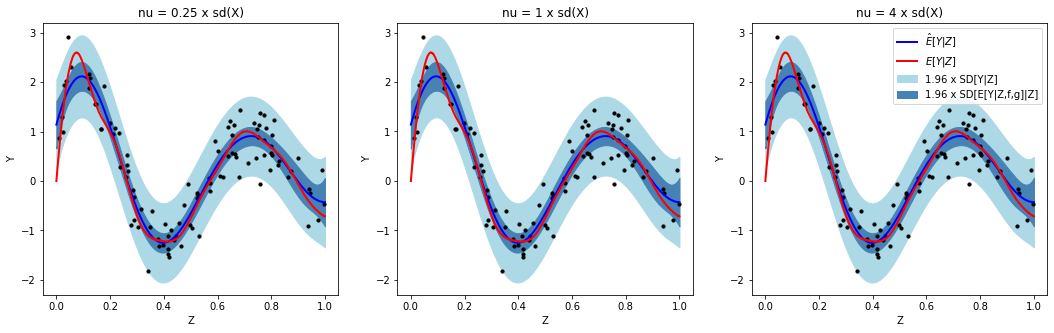

In [53]:
fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))

for k in range(len(nulist)):
    K_xx_tilde_s = get_smoothed_Gaussian_kernel(X, kernel_params_x.detach(), mc_approx = True, mc_samples = 10**5, nu = nu)
    eigs_s_sum = get_Gaussian_kernel_eigs(X, kernel_params_x.detach(), mc_approx = True, mc_samples = 10**3, nu = nu).sum()

    EY_Z = marginal_posterior_mean(Y, X, Z, Ztest, 
                                kernel_params_x, kernel_params_z, 
                                torch.exp(y_noise), torch.exp(z_noise)).detach()

    Var_EY_Z = torch.diag(marginal_posterior_covariance(Y,X,Z,
                                       Ztest,[], torch.exp(y_noise), torch.exp(z_noise),
                                       kernel_params_x,kernel_params_z,
                                       K_xx_tilde_s, eigs_s_sum, latent = True))
    Var_Y_Z = torch.diag(marginal_posterior_covariance(Y,X,Z,
                                       Ztest,[], torch.exp(y_noise), torch.exp(z_noise),
                                       kernel_params_x,kernel_params_z,
                                       K_xx_tilde_s, eigs_s_sum, latent = False))

    Mean = EY_Z.detach().numpy()
    Var_EY_Z = Var_EY_Z.detach().numpy()
    Var_Y_Z = Var_Y_Z.detach().numpy()
    
    # Plotting conditional average treatment effect mean +- sd
    indices = torch.argsort(Ztest,0)[:,0]
    indices_train = torch.argsort(Z,0)[:,0]
    Upper = (Mean[indices]+z_val*np.sqrt(Var_Y_Z[indices]))
    Lower = (Mean[indices]-z_val*np.sqrt(Var_Y_Z[indices]))
    axs[k].plot(Ztest[indices],EY_Z[indices], label = r"$\hat E[Y|Z]$", color = "blue", linewidth = 2)
    axs[k].plot(Ztest[indices],EY_Z_true[indices], label = r"$ E[Y|Z]$", color = "red", linewidth = 2)
    axs[k].fill_between(Ztest[indices][:,0],Upper,Lower, color = "lightblue", alpha=1.0, edgecolor='none', label = "1.96 x SD[Y|Z]")
    Upper = (Mean[indices]+z_val*np.sqrt(Var_EY_Z[indices]))
    Lower = (Mean[indices]-z_val*np.sqrt(Var_EY_Z[indices]))
    axs[k].fill_between(Ztest[indices][:,0],Upper,Lower, color = "steelblue", alpha=1.0, edgecolor='none', label = "1.96 x SD[E[Y|Z,f,g]|Z]")
    axs[k].scatter(Z,Y, s = 10, color = "black")
    axs[k].set_title("nu = " + str(2**(-2+2*k))+" x sd(X)")
    axs[k].set_xlabel("Z")
    axs[k].set_ylabel("Y")
plt.legend()
plt.show()
fig.savefig("d=25_ours", bboxinches = "tight")